In [1]:
# note: datahub.io has good datasets

In [2]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy, math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# load the data
df = pd.read_csv('data/cars.csv')
print(df.shape)

# drop the rows with missing values
df = df.fillna(df.mean(numeric_only=True))

# for cars.csv:
target = df[['MSRP']]
predictors = df.drop('MSRP', axis=1).select_dtypes(exclude=object)

(11914, 16)


In [4]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(predictors, target, train_size=0.7, test_size=0.3)

In [5]:
# scale/normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# convert to numpy arrays
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [7]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train shape: (8339, 7)
X_test.shape: (3575, 7)
y_train.shape: (8339, 1)
y_test.shape: (3575, 1)


In [8]:
# initial parameters
m, n = X_train.shape
w_init = np.zeros(n)
b_init = 0.0

print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")


w_init shape: (7,), b_init type: <class 'float'>


The model's prediction with multiple variables is given by the linear model:
$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b \tag{1}$$
or in vector notation:
$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b  \tag{2} $$ 
where $\cdot$ is a vector `dot product`

In [9]:
def predict(X, w, b):
  '''
  Predict values using weights and inputs
  
  Args:
  X (ndarray (m,n)) : examples with multiple features
  w (ndarray (n,))  : model parameters
  b (scalar)        : model parameter

  Returns:
  p (scalar)        : prediction 
  '''

  p = np.dot(X, w) + b
  p = p.reshape(-1,1)

  return p

In [10]:
predict(X_train, w_init, b_init).shape

(8339, 1)

The equation for the cost function with multiple variables $J(\mathbf{w},b)$ is:
$$J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2 \tag{3}$$ 
where:
$$ f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = \mathbf{w} \cdot \mathbf{x}^{(i)} + b  \tag{4} $$ 

In [11]:
def compute_cost(X, y, w, b):
  '''
  Computes cost for a model using current parameters
  
  Args:
  X (ndarray (m,n)) : data, m examples with n features
  y (ndarray (m,))  : target values
  w (ndarray (n,))  : model parameters
  b (scalar)        : model parameter
  
  Returns:
  cost (scalar)     : cost
  '''

  m,_ = X.shape
  pred = predict(X, w, b)
  cost = ((pred - y)**2).sum()
  cost = cost / (2 * m)

  return cost

In [12]:
compute_cost(X_train, y_train, w_init, b_init)

2458356202.0613384

Gradient descent for multiple variables:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{6}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{7}
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value

In [29]:
def compute_gradient(X, y, w, b):
  '''
  Computes the gradient(slope of cost function)

  Args:
  X (ndarray (m,n))    : data, m examples with n features
  y (ndarray (m,))     : target values
  w (ndarray (n,))     : model parameters
  b (scalar)           : model parameter

  Returns:
  dj_dw (ndarray (n,)) : gradient of the cost w.r.t. the parameters w
  dj_db (scalar)       : gradient of the cost w.r.t. the parameter b
  '''

# non-vectorized implementation
#   m,n = X.shape           #(number of examples, number of features)
#   dj_dw = np.zeros(n,)
#   dj_db = 0.

#   for i in range(m):                             
#       err = predict(X, w, b)[i] - y[i]   
#       for j in range(n):                         
#           dj_dw[j] = dj_dw[j] + err * X[i, j]    
#       dj_db = dj_db + err                        
#   dj_dw = dj_dw / m                                
#   dj_db = dj_db / m

  # vectorized implementation
  m, _ = X.shape
  err = predict(X, w, b) - y
  dj_dw = np.dot(X.T, err) / m
  dj_db = err.sum() / m
      
  return dj_db, dj_dw

In [30]:
# compute and display gradient
tmp_dj_db, tmp_dj_dw = compute_gradient(X_train, y_train, w_init, b_init)
print(f'dj_db at initial w,b: {tmp_dj_db}')
print(f'dj_dw at initial w,b: \n {tmp_dj_dw}')
print(f'dj_dw shape: {tmp_dj_dw.shape}')

dj_db at initial w,b: -40503.713514809926
dj_dw at initial w,b: 
 [[-13693.54829607]
 [-38633.87824088]
 [-31457.72590741]
 [  7260.09259695]
 [ 10599.45698611]
 [  9856.38637625]
 [  3100.4263704 ]]
dj_dw shape: (7, 1)


In [43]:
print(tmp_dj_dw * 5.0e-7)

[[-0.00684677]
 [-0.01931694]
 [-0.01572886]
 [ 0.00363005]
 [ 0.00529973]
 [ 0.00492819]
 [ 0.00155021]]


In [40]:
def gradient_descent(X, y, w, b, alpha, num_iters):
  '''
  Performs gradient descent to minimize the cost function

  Args:
  X (ndarray (m,n))    : data, m examples with n features
  y (ndarray (m,))     : target values
  w (ndarray (n,))     : model parameters
  b (scalar)           : model parameter
  alpha (scalar)       : learning rate
  num_iters (int)      : number of iterations

  Returns:
  w (ndarray (n,))     : model parameters
  b (scalar)           : model parameter
  '''

  # store the cost for each iteration
  costs = []
  print(predict(X, w, b))
  print(y.shape)
  
  for i in range(num_iters):
    dj_dw, dj_db = compute_gradient(X, y, w, b)
    w = w - alpha * dj_dw
    b = b - alpha * dj_db

    # compute the cost
    # prevent resource exhaustion
    if i<100000:
      print(predict(X, w, b))
      print(y.shape)
      costs.append(compute_cost(X, y, w, b))

    # print cost 10 times
    if i % (num_iters//10) == 0:
      print(f'Cost at iteration {i}: {costs[-1]}')

  return w, b, costs

In [44]:
# initialize parameters
initial_w = np.zeros_like(w_init)
initial_b = 0.0

# initialize hyperparameters
alpha = 5.0e-7
num_iters = 1000

# run gradient descent
w_final, b_final, J_hist = gradient_descent(X_train, y_train, initial_w, initial_b, alpha, num_iters)

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
(8339, 1)
[[-0.02072917]
 [ 0.07054597]
 [ 0.0149114 ]
 ...
 [ 0.04488362]
 [-0.01911897]
 [-0.04050215]]
(8339, 1)


ValueError: operands could not be broadcast together with shapes (58373,1) (8339,1) 

In [26]:
print(f'w, b found by gradient descent: {w_final}, {b_final:0.2f}')

m,_ = X_train.shape
for i in range(m):
    print(
        f'prediction: {predict(X_train, w_final, b_final)[i]:0.2f}, target value: {y_train[i]}')


w, b found by gradient descent: [ 0.20396569  0.00374919 -0.0112487  -0.0658614 ], -0.00
prediction: 426.19, target value: 460
prediction: 286.17, target value: 232
prediction: 171.47, target value: 178


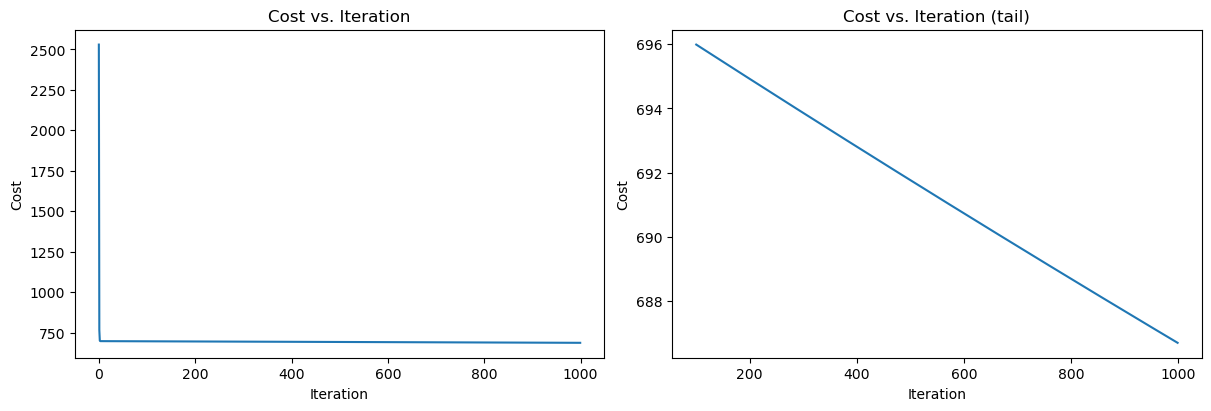

In [27]:
# plot cost versus iteration
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))

ax1.plot(J_hist)
ax2.plot(100 + np.arange(len(J_hist[100:])), J_hist[100:])

ax1.set_xlabel('Iteration')         ; ax2.set_xlabel('Iteration')
ax1.set_ylabel('Cost')              ; ax2.set_ylabel('Cost')
ax1.set_title('Cost vs. Iteration') ; ax2.set_title('Cost vs. Iteration (tail)')

plt.show()